In [26]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [27]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment, KolmogorovEnvironment2
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer_size", type=int, default=20000)
    parser.add_argument("--max_epoch", type=int, default=10)
    parser.add_argument("--step_per_epoch", type=int, default=100)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=2)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.90)
    parser.add_argument("--lr", help='learning rate', type=float, default=1e-4)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--step_per_collect", type=int, default=200) 
    parser.add_argument("--architecture", type=int, default=[64, 64])
    parser.add_argument("--backbone_out_dim", type=int, default=64)

    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2, min_a=-1., max_a=1., step_factor=10, max_t=100):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment2(kwargs1, kwargs2, step_factor=step_factor, max_episode_steps=max_t)
    #env = TimeLimit(env, max_episode_steps=max_t)
    return env


class Backbone(nn.Module):

    def __init__(self, out_size=64, device="cpu"):
        super(Backbone, self).__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(2, 4, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
        )
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(512, out_size),
            nn.ReLU(True),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=device)
        batch = obs.shape[0]

        obs = self.encoder_cnn(obs.reshape(batch, 1, 128, 128))
        obs = obs.reshape(batch, -1)
        logits = self.encoder_lin(obs)

        return logits, state

In [31]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
#restrict_to_num_threads(1)

In [32]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
step_factor=10
#check if cgs time is a factor of fgs time
assert (T2%T1 == 0)
env = create_env(kwargs1, kwargs2, step_factor=step_factor,  max_t=100)
train_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.train_num)])
test_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.test_num)])
check_env(env)

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0
m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


KeyboardInterrupt: 

In [ ]:
# play an episode of length T = 100, for each alpha in alphas and plot totoal reward
alphas = np.linspace(env.action_space.low[0], env.action_space.high[0], 20)
alphas = alphas.reshape(-1,1)
rewards = np.zeros_like(alphas)
T = 100
for i in range(alphas.shape[0]):
    alpha = alphas[i]
    reward = 0
    step = 0
    obs, inf = env.reset()
    for step in tqdm(range(T)):
        obs, rew, terminated, truncated, inf = env.step(alpha)
        reward+=rew
        if terminated or truncated:
            obs, inf = env.reset()
            print("termination")
            rewards[i] = reward
            break
    # Close the environment and display
    env.close()
    print(f"alpha={alpha[0]} --> reward: {reward}, length: {step}")
    rewards[i] = reward

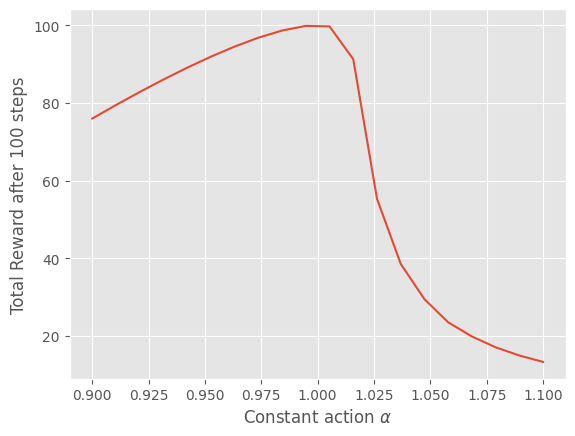

In [ ]:
plt.style.use('ggplot')
plt.figure()
plt.plot(alphas, rewards)
plt.xlabel(r"Constant action $\alpha$")
plt.ylabel(f"Total Reward after {T} steps")
plt.show()

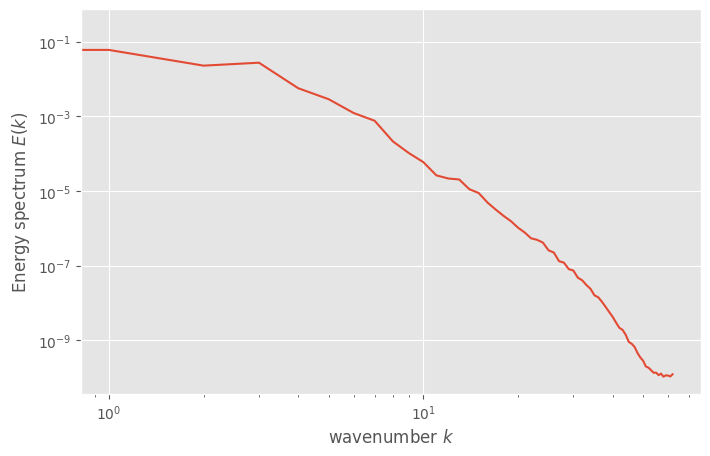

In [6]:
obs, inf = env.reset()
# plot the spectrum
plt.style.use('ggplot')
plt.figure(figsize=(8, 5), dpi=100)
plt.loglog(obs)
plt.ylabel(r'Energy spectrum $E(k)$')
plt.xlabel(r'wavenumber $k$')
#plt.legend()
plt.show()

In [33]:
#train a simple policy gradient alogorithm instead of PPO first
net = Net(state_shape=env.observation_space.shape, hidden_sizes=[32, 16], device=device).to(device)
actor = ActorProb(preprocess_net=net, action_shape=env.action_space.shape, max_action=1, device=device).to(device)
optim = torch.optim.AdamW(actor.parameters(), lr=args.lr)
dist = torch.distributions.Normal

#policy=PGPolicy(model=actor, optim=optim, dist_fn=dist)

policy = PGPolicy(
    model=actor,
    optim=optim,
    dist_fn=dist,
    action_space=env.action_space,
    discount_factor=0.97,
    reward_normalization=False,
    deterministic_eval=True,
    observation_space=env.observation_space,
    action_scaling=True,
    action_bound_method = "tanh",
)

In [34]:
#Collectors
train_collector = Collector(
    policy=policy,
    env=train_env,
    buffer=VectorReplayBuffer(args.buffer_size, len(train_env)),
)
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()


#Trainer
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=10,
    step_per_epoch=101,
    repeat_per_collect=1,
    episode_per_test=1,
    batch_size=100,
    episode_per_collect=1,
    show_progress=True,
)

In [35]:
N = trainer.max_epoch
rew_stats = np.zeros((N,2))
trainer.reset()
i=0
for step_stats in trainer:
    rew_stats[i,0] = step_stats[1]['test_reward']
    rew_stats[i,1] = step_stats[1]['test_reward_std']
    i+=1
    

Epoch #1: 105it [00:36,  2.89it/s, env_step=105, len=10, loss=-1.380, n/ep=1, n/st=10, rew=7.64]                        


Epoch #1: test_reward: 69.055893 ± 0.000000, best_reward: 69.132923 ± 0.000000 in #0


Epoch #2: 102it [00:07, 13.34it/s, env_step=206, len=101, loss=2.072, n/ep=1, n/st=101, rew=70.65]                         


Epoch #2: test_reward: 69.000567 ± 0.000000, best_reward: 69.132923 ± 0.000000 in #0


Epoch #3: 115it [00:22,  5.11it/s, env_step=321, len=85, loss=3.418, n/ep=1, n/st=85, rew=46.04]                        


Epoch #3: test_reward: 68.858125 ± 0.000000, best_reward: 69.132923 ± 0.000000 in #0


Epoch #4: 102it [00:32,  3.17it/s, env_step=422, len=28, loss=3.755, n/ep=1, n/st=28, rew=14.14]                         


Epoch #4: test_reward: 68.701335 ± 0.000000, best_reward: 69.132923 ± 0.000000 in #0


Epoch #5: 105it [00:31,  3.35it/s, env_step=527, len=20, loss=4.426, n/ep=1, n/st=20, rew=9.97]                         


Epoch #5: test_reward: 68.676866 ± 0.000000, best_reward: 69.132923 ± 0.000000 in #0


Epoch #6:  31%|###       | 31/101 [00:08<00:18,  3.82it/s, env_step=558, len=31, loss=4.495, n/ep=1, n/st=31, rew=15.78]

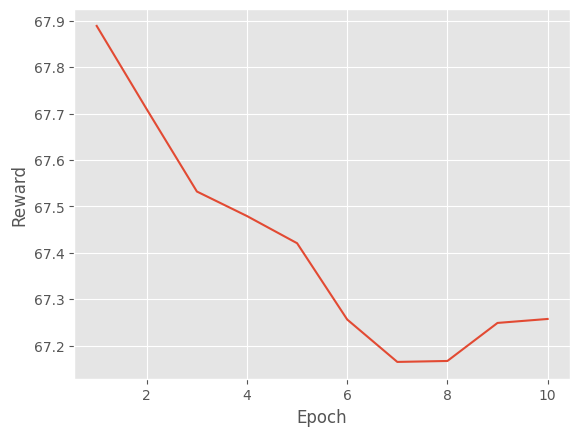

In [18]:
episodes = np.linspace(1,N, N)
plt.style.use('ggplot')
plt.figure()
plt.plot(episodes, rew_stats[:,0])
#plt.scatter(episodes, rew_stats[:,0])
plt.fill_between(episodes, rew_stats[:,0]+rew_stats[:,1], rew_stats[:,0]-rew_stats[:,1], alpha=0.5)
plt.ylabel(r"Reward")
plt.xlabel(r"Epoch")
plt.show()

step: 50, actual_steps: 500, action: [0.9846742]
0.9909549417704515


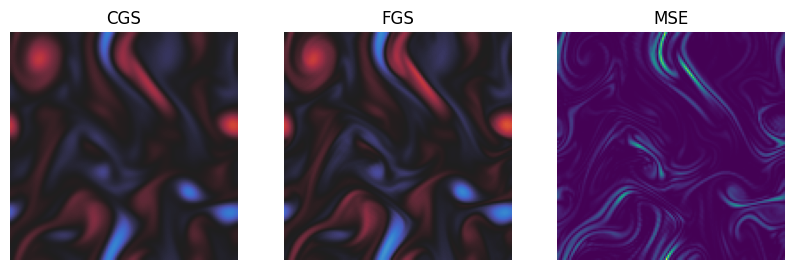

step: 100, actual_steps: 1000, action: [0.9846215]
0.9783592650510665


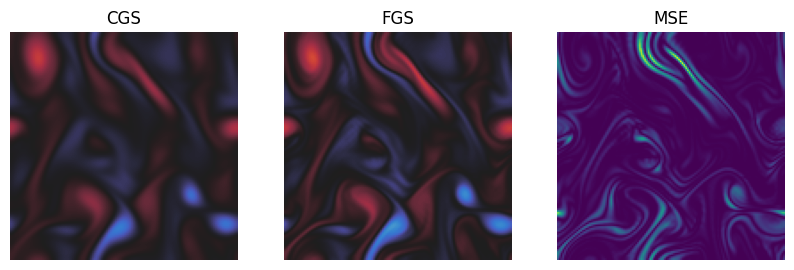

truncated
#steps = 101, Total Reward = 68.06680585746447


In [11]:
reward = 0
step = 0
policy.eval()
obs ,inf = env.reset()
episode_is_over = False
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy().reshape(-1)
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if step%50==0:
        print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

step: 50, actual_steps: 500, action: 1.0
1.0


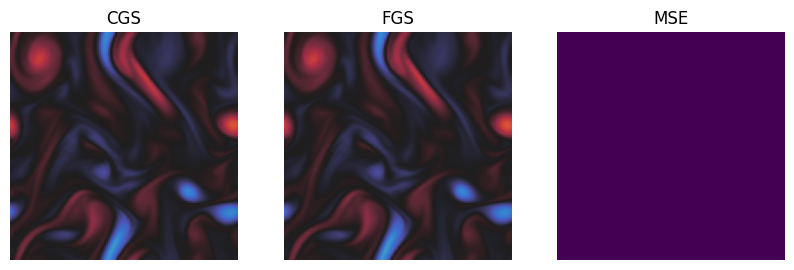

step: 100, actual_steps: 1000, action: 1.0
1.0


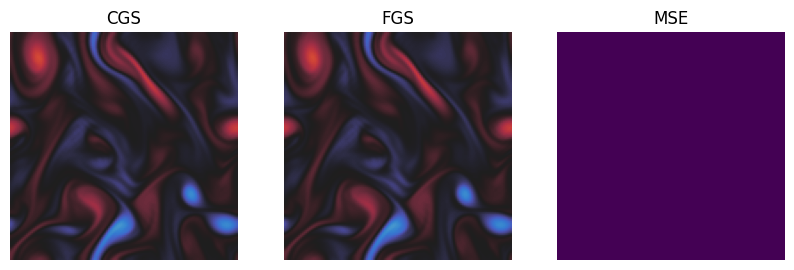

truncated
#steps = 101, Total Reward = 100.99999999999999


In [13]:
#compare to naive, correct policy
reward = 0
step = 0
obs ,inf = env.reset()
episode_is_over = False
while not episode_is_over:
    obs, rew, terminated, truncated, inf = env.step(np.array([1.]))
    reward += rew
    step += 1
    if step%50==0:
        print(f"step: {step}, actual_steps: {env.counter}, action: {1.}")
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

In [23]:
#find whats the worst performance
low_act = env.action_space.low
high_act = env.action_space.high

In [25]:

reward = 0
step = 0
obs ,inf = env.reset()
episode_is_over = False
while not episode_is_over:
    obs, rew, terminated, truncated, inf = env.step(high_act)
    reward += rew
    step += 1
    if step%50==0:
        print(f"step: {step}, actual_steps: {env.counter}, action: {1.}")
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

terminated
#steps = 2, Total Reward = -0.4442957345694627
